In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from nonlocalunet.models import NonLocalUnet
from liverfiles.metrics import dr_score, mhd_score
from liverfiles.Trainer import Trainer
from liverfiles.utils import get_nii, get_mask, min_max, to_uint
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from liverfiles.loader import Ds

import random

# Data

In [2]:
def preprocess(img, mask, size):
    depth_idx = list(range(0, img.shape[-1], img.shape[-1]//size[-1]))[:size[-1]]
    img = img[:,:,depth_idx]
    img = to_uint(img)
    img = cv2.resize(img, (size[0],size[1]))
    mask = mask[:,:,depth_idx]
    mask = cv2.resize(mask, (size[0],size[1]))
    return img, mask

In [3]:
pathes = []
for (dirpath, dirnames, filenames) in os.walk('data'):
    if dirpath == os.path.join('data', 'segmentations'):
        continue
    pathes.extend([os.path.join(dirpath, i)for i in filenames] )
df = pd.DataFrame({'path': pathes})
df['id'] = df.path.str.split(os.path.sep).str[-1].str[7:-4]
df.id = df.id.astype('int16')
df = df.sort_values(by='id').reset_index(drop=True)

In [4]:
imgs, masks = [], []
size = (128,128, 64)
for path, mask_id in df.values:
    img, mask = preprocess(get_nii(path), get_mask(mask_id), size)
    imgs.append(img)
    masks.append(mask)

# Dataloader

In [5]:
shape = (32, 32, 32)

val_size = 1
train_ds = Ds(imgs, masks, shape, None)

train_dl = DataLoader(train_ds,
                      batch_size=3,
                      shuffle=True,
                      num_workers=8,
                      pin_memory=False,
                      drop_last=False)

val_df = df.iloc[[0]]
# val_ds = Ds(df[-val_size:], shape, None)
# val_dl = DataLoader(val_ds,
#                      batch_size=3,
#                      shuffle=False,
#                      num_workers=8,
#                      pin_memory=False,
#                      drop_last=False)
#test1, test2 = next(iter(train_dl))

# Visualization

In [4]:
a, b = next(iter(train_dl))
c = 0

(512, 512, 75) (512, 512, 75)
(512, 512, 123) (512, 512, 123)
(512, 512, 466) (512, 512, 466)
(512, 512, 501) (512, 512, 501)
(512, 512, 518) (512, 512, 518)
(512, 512, 605) (512, 512, 605)
(512, 512, 541) (512, 512, 541)
(512, 512, 841) (512, 512, 841)
(512, 512, 517) (512, 512, 517)
(512, 512, 588) (512, 512, 588)
(512, 512, 537) (512, 512, 537)
(512, 512, 455) (512, 512, 455)
(512, 512, 534) (512, 512, 534)
(512, 512, 549) (512, 512, 549)
(512, 512, 541) (512, 512, 541)


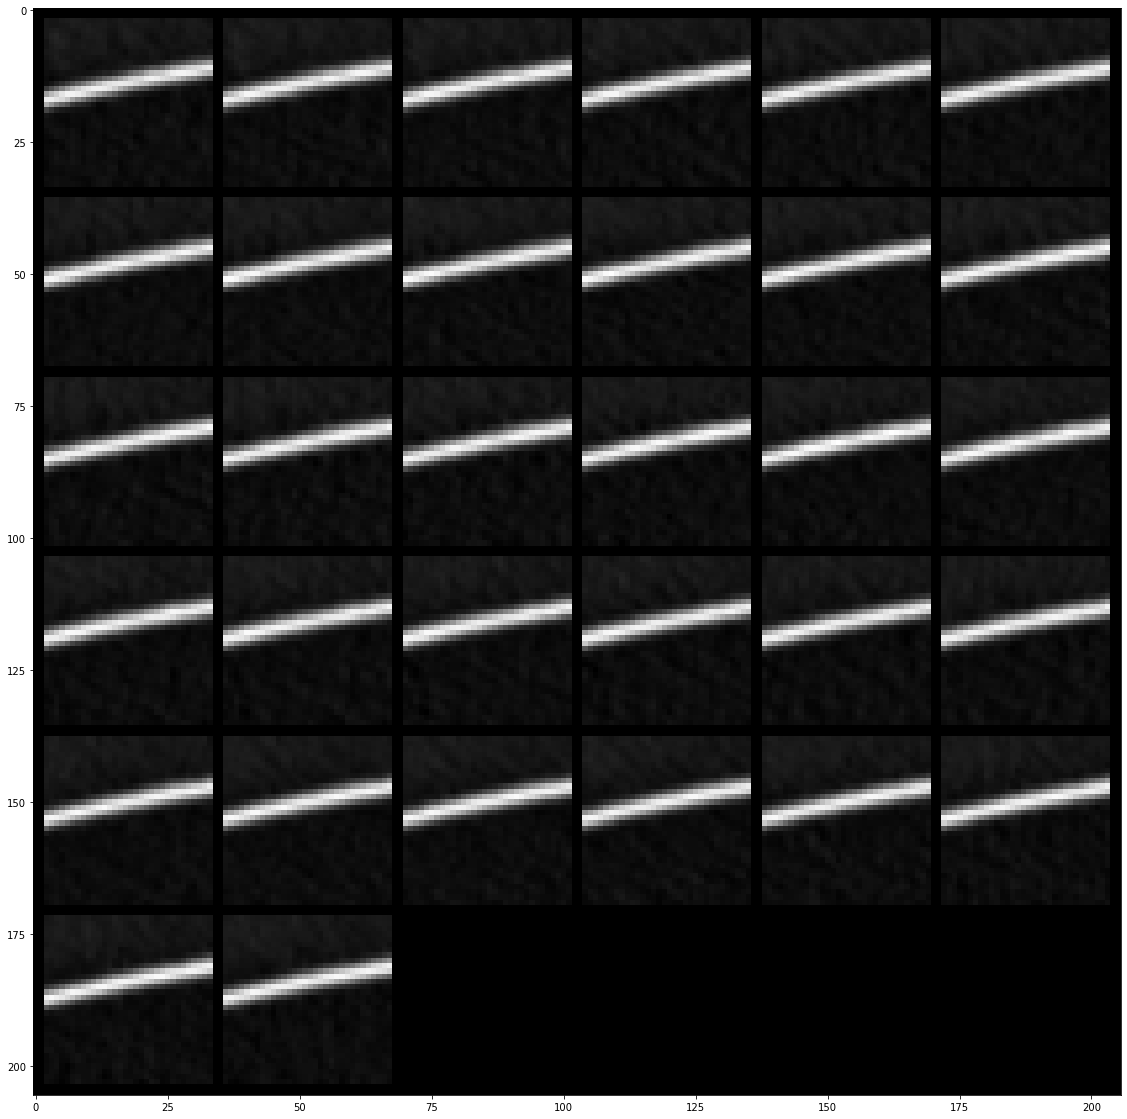

In [5]:
example = torchvision.utils.make_grid(torch.transpose(a[c], 0,1), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))

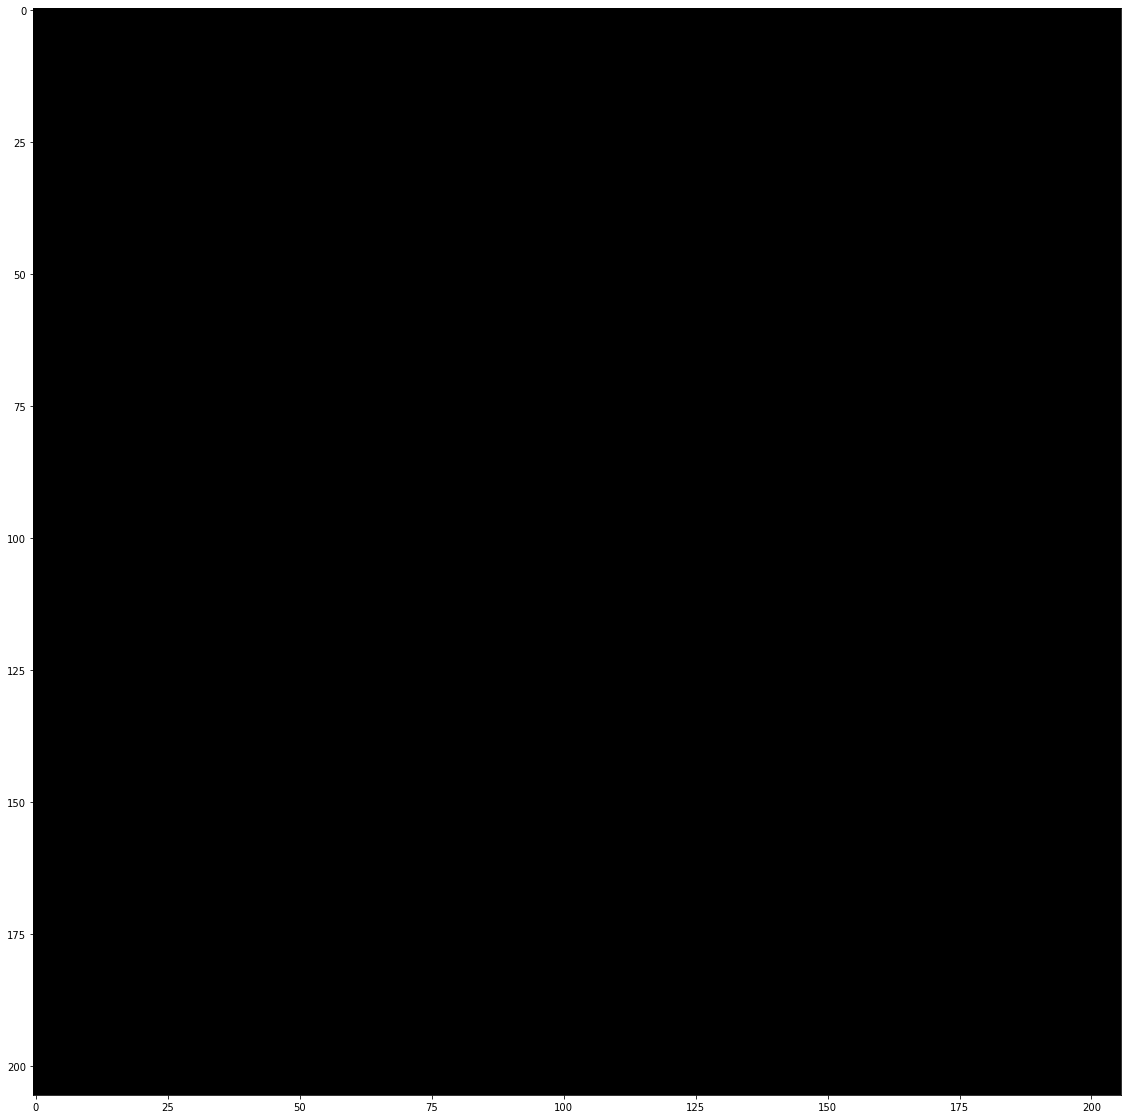

In [6]:
example = torchvision.utils.make_grid(torch.transpose(b[c], 0,1)[:,0:1,:,:].float(), nrow=6)
plt.figure(figsize=(20,20))
plt.imshow(example.permute(1,2,0))
c+=1

# Model

In [6]:
model = NonLocalUnet(1, 2).to('cuda')
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCELoss()
device = 'cuda'

In [7]:
trainer = Trainer(model, optimizer, scheduler, criterion, train_dl, val_df, device, 'first run')

In [8]:
trainer.train(10)

/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/metrics.py:27: UserWarning: `x` isn't a recognized object; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result_by_channel += max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/Trainer.py", line 206, in train
    val_metrics, x, preds, labels = self.validate()
  File "/home/aykhan123/anaconda3/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 26, in decorate_context
    return func(*args, **kwargs)
  File "/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/Trainer.py", line 166, in validate
    temp_metrics = count_metrics(labels, preds, "Val")
  File "/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/metrics.py", line 60, in count_metrics
    f'{mode} 3D-MHD': mhd_score(gt, preds)}
  File "/home/aykhan123/Desktop/job/Non-local-U-Net-Pytorch/liverfiles/metrics.py", line 26, in mhd_score
    b = b.reshape((b.shape[0], b.shape[1] * b.shape[2]))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aykhan123/anaconda3/lib/python3.8/site-pa

TypeError: object of type 'NoneType' has no len()